#**Практическое задание №1**

Установка необходимых пакетов:

In [ ]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [ ]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = { #собственные ссылки на наборы, т.к. советывали так сделать
    'train': "1T5z6OPLoYUANn-_B14PSngZFm0mIOgsU",
    'train_small': "18v_U5xFYI3V9lIeewZ8WEUcX5Gwbn0hH",
    'train_tiny': "1CD-hIDZ8eWjSC4lz7Z6jy61OSUczujkC",
    'test': "1yrhk65_BzfPHDQpGPCZN4h8qwIeEmil2",
    'test_small': "1E2oMNP7YeS0Bs-xvRugAgYdEp-TvuDaW",
    'test_tiny': "1F0ve7Cl7c7Ln-7hoQLbFauaAjsVAh1g7"
}

Импорт необходимых зависимостей:

In [ ]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import time
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision.transforms import v2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [ ]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1CD-hIDZ8eWjSC4lz7Z6jy61OSUczujkC
To: /content/train_t

Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 6.
Label code corresponds to NORM class.


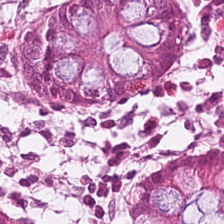

In [ ]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [ ]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

#Функция **k_folds**

Проверка входных данных:
Проверяет, чтобы количество фолдов было хотя бы 2, и чтобы общее количество объектов было больше или равно количеству фолдов

Определение размера фолдов:
Равномерно делит количество объектов на фолды
Если объекты не делятся нацело на количество фолдов, остаток добавляется к первичным фолдам

Создание индексов для фолдов:
Генерирует массив индексов объектов
Делит объекты на фолды
для каждого фолда создаются два массива
Обучающие индексы (train_indices)
Все объекты, за исключением объектов текущего фолда
Тестовые индексы (test_indices) Объекты текущего фолда

Возврат:
Возвращает список кортежей, где каждый кортеж содержит два массива:
Обучающие индексы,
Тестовые индексы.


Пример разбиения для 10 объектов и 3 фолдов:
Размеры фолдов [4, 3, 3]
Индексы объектов [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Разбиение:
Фолд 1: обучающие индексы [4, 5, 6, 7, 8, 9], тестовые индексы [0, 1, 2, 3]
Фолд 2: обучающие индексы [0, 1, 2, 3, 7, 8, 9], тестовые индексы [4, 5, 6]
Фолд 3: обучающие индексы [0, 1, 2, 3, 4, 5, 6], тестовые индексы [7, 8, 9]

In [ ]:
#функция для разбиения данных на фолды
def k_folds(num_objects: int, num_folds: int) -> list[tuple[np.ndarray, np.ndarray]]:
    if num_folds < 2:
        raise ValueError("Split count must be at least 2")
    if num_objects < num_folds:
        raise ValueError("Total items must be greater than or equal to the number of splits")

    fold_sizes = [num_objects // num_folds] * num_folds
    for i in range(num_objects % num_folds):
        fold_sizes[i] += 1

    indices = np.arange(num_objects, dtype=np.int32)
    splits = []
    start = 0
    for fold_size in fold_sizes:
        test_indices = indices[start:start + fold_size]
        train_indices = np.concatenate((indices[:start], indices[start + fold_size:]))
        splits.append((train_indices, test_indices))
        start += fold_size

    return splits

In [ ]:
#определение архитектуры модели ResNet18 для классификации изображений
def create_model(base_model, num_ftrs, num_classes):
    for param in base_model.parameters():
        param.requires_grad = False

    num_ftrs = base_model.fc.in_features
    base_model.fc = torch.nn.Linear(num_ftrs, num_classes)
    return base_model

# класс **Dataloader**

Аргументы конструктора:
dataset: Датасет, который предоставляет изображения и метки

indices: Индексы объектов в датасете, которые будут использованы для создания выборки

batch_size: Размер пакета(батча), который будет извлечён из выборки за одну итерацию

transforms: Преобразования, которые будут применяться к изображениям

augmenting_transforms: Аугментации для увеличения разнообразия данных

limit: Процент данных, который нужно использовать(от 0 до 1)


Итератор:
iter: Метод, который возвращает сам объект и инициализирует итерацию, перемешивая индексы данных для каждой новой итерации

next: Метод, который извлекает следующий батч данных, используя индексы
Каждое изображение:
  Загружается из датасета
  Применяются аугментации и трансформации, если они заданы

Обработка батчей:
Тензоры batch_images и batch_labels заполняются для каждого индекса в текущем батче

Преобразования и аугментации могут применяться в любом порядке, в зависимости от того, как они передаются в конструктор

Сохранение изображений в нужном формате:
Изображения преобразуются в тензоры с размерностью (batch_size, 3, 224, 224) что соответствует формату, используемому в большинстве CNN

Перемешивание индексов:
В iter индексы перемешиваются перед каждой итерацией, что помогает улучшить обобщающую способность модели за счет случайности в выборке данных

In [ ]:
class Dataloader:
    def __init__(self, dataset: Dataset, indices: np.ndarray, batch_size: int, transforms=None, augmenting_transforms=None, limit=1.0):
        if not (0 < limit <= 1.0):
            raise ValueError("Data limit must be between 0 and 1")

        self.dataset = dataset
        self.indices = indices[:int(len(indices) * limit)]
        self.batch_size = batch_size
        self.transforms = transforms
        self.augmenting_transforms = augmenting_transforms
        self.num_batches = len(self.indices) // batch_size
        self.current_batch_idx = 0

    def __iter__(self):
        self.current_batch_idx = 0
        np.random.shuffle(self.indices)
        return self

    def __next__(self):
        if self.current_batch_idx < self.num_batches:
            batch_start = self.current_batch_idx * self.batch_size
            batch_end = batch_start + self.batch_size
            selected_indices = self.indices[batch_start:batch_end]

            batch_images = torch.empty((self.batch_size, 3, 224, 224), dtype=torch.float32)
            batch_labels = torch.empty(self.batch_size, dtype=torch.long)

            for idx, data_idx in enumerate(selected_indices):
                image, label = self.dataset.image_with_label(data_idx)
                image = torch.from_numpy(image).permute(2, 0, 1)

                if self.augmenting_transforms:
                    image = self.augmenting_transforms(image)
                if self.transforms:
                    image = self.transforms(image)

                batch_images[idx] = image
                batch_labels[idx] = torch.tensor(label)

            self.current_batch_idx += 1
            return batch_images, batch_labels
        else:
            raise StopIteration

# класс **CrossValidator**

Аргументы конструктора init:
dataset: набор данных, который будет разделён на фолды

batch_size: размер батча для обучения и валидации

num_folds: число фолдов для кросс-валидации. Должно быть не менее 2

transforms: преобразования, применяемые к данным в процессе обучения

augmenting_transforms: аугментации для увеличения разнообразия данных

seed: фиксация случайности для воспроизводимости

limit: ограничения размера данных для обучающей и валидационной выборов(значения в диапазоне (0, 1])

In [ ]:
#LBL2
class CrossValidator:
    def __init__(self, dataset: Dataset, batch_size: int, num_folds: int, transforms=None, augmenting_transforms=None, seed=42, limit=(1.0, 1.0)):
        if num_folds < 2:
            raise ValueError("Number of folds must be at least 2")
        if len(limit) != 2 or not all(0 < value <= 1 for value in limit):
            raise ValueError("Data limits must be within the range 0 and 1")

        self.dataset = dataset
        self.batch_size = batch_size
        self.num_folds = num_folds
        self.transforms = transforms
        self.augmenting_transforms = augmenting_transforms
        self.limit = limit

        self.indices = np.arange(dataset.n_files)
        np.random.seed(seed)
        np.random.shuffle(self.indices)

        self.fold_indices = k_folds(len(self.indices), num_folds)
        self.current_fold = 0

    def get_train_val(self):
        train_idx = self.indices[self.fold_indices[self.current_fold][0]]
        val_idx = self.indices[self.fold_indices[self.current_fold][1]]

        self.current_fold = (self.current_fold + 1) % self.num_folds

        return (
            Dataloader(self.dataset, train_idx, self.batch_size,
                       self.transforms, self.augmenting_transforms, limit=self.limit[0]),
            Dataloader(self.dataset, val_idx, self.batch_size,
                       self.transforms, self.augmenting_transforms, limit=self.limit[1])
        )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#LBL8 #LBL6 #LBL4
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(" ".join(["Loss", title_suffix]))
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title(' '.join(["Validation accuracy", title_suffix]))
    axes[1].plot(train_accuracy, label="train")
    axes[1].plot(val_accuracy, label="validation")
    axes[1].legend()
    plt.show()

# Матрица Ошибок

матрицы ошибок, которая показывает, как предсказания модели соотносятся с истинными метками классов.
Функция также вычисляет True Positive (TP) и False Positive (FP) для каждого класса.

Используем confusion_matrix из библиотеки sklearn для подсчёта количества совпадений между предсказанными и истинными метками классов.

Визуализируем матрицу ошибок:
Построение тепловой карты (heatmap) с использованием библиотеки seaborn для наглядного отображения.

Вычисляет метрики для каждого класса:
TP (True Positive): Количество правильных предсказаний для данного класса.
FP (False Positive): Количество случаев, когда данный класс был предсказан неправильно.
Выводит метрики в табличной форме.


In [ ]:
def confi_matrix(gt: List[int], pred: List[int], class_names: List[str]):
    matrix = confusion_matrix(gt, pred)

    plt.figure(figsize=(10, 8), dpi=100)
    sns.heatmap(matrix,
                xticklabels=class_names,
                yticklabels=class_names,
                cmap='RdYlGn',
                center=0,
                annot=True,
                fmt="d",
                cbar_kws={'label': 'Number of Samples'})

    plt.title('Confusion Matrix', fontsize=22, pad=20)
    plt.xlabel('Predicted Labels', fontsize=16, labelpad=10)
    plt.ylabel('True Labels', fontsize=16, labelpad=10)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.show()

    TP = np.diag(matrix)
    FP = matrix.sum(axis=0) - TP

    print(f"{'Class':<15}{'True Positive (TP)':<20}{'False Positive (FP)':<20}")
    print("-" * 55)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15}{TP[i]:<20}{FP[i]:<20}")

## **Почему так**
Изначально я пытался сделать с помощью классического МЛ'ля, но перенабивание ОЗУ я не осилил.
По советам уже знающих людей, решил сделать именно свертку, да и примеров на том же Гитхабе и кагле было достаточно, что бы человек в первые который с этим знакомится мог что-то и написать, ну, я брал идеи и части кода других, но в основном все делалось с моей руки и могу даже защитить данную работу.

Я использую предобученную модель ResNet18 и дообучаю ее на новом наборе данных, чтобы она научилась классифицировать изображения на заданных классах.
Даже попытался предотвратить переобучение, но, не знаю, наверное надо было брать меньше эпох.

На чем тестировал:
На полном тесте:
accuracy 0.9847,
balanced accuracy 0.9847

На маленьком тесте:
accuracy 0.9667,
balanced accuracy 0.9667

In [ ]:
class Model:
    def __init__(self):
        self.model = create_model(torchvision.models.resnet18(pretrained=True), 6, 9).to(device)
        self.transforms = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

    def save(self, name: str):
        torch.save(self.model.state_dict(), f'/content/drive/MyDrive/DP/{name}.pth')

    def load(self, name: str):
        name_to_id_dict = {
            "best": '1-KG_C4OaeYnh9DpB4GH0_fdUoLK706Fg'
        }
        output = f"{name}.pth"
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)

        self.model.load_state_dict(torch.load(output))
        self.model.to(device)
        self.model.eval()
    #LBL1
    def evaluate(self, dataloader: Dataloader, loss_fn, weights):
        losses = []
        num_correct = np.zeros(9, dtype=int)
        num_elements = np.zeros(9, dtype=int)

        for batch in dataloader:
            X_batch, y_batch = batch
            with torch.no_grad():
                logits = self.model(X_batch.to(device))
                loss = loss_fn(logits, y_batch.to(device))
                losses.append(loss.item())

                y_pred = torch.argmax(logits, dim=1).cpu()
                num_elements += (y_batch.numpy()[:, None] == np.arange(9)).sum(axis=0)
                num_correct += ((y_pred.numpy()[:, None] == np.arange(9)) & (y_pred.numpy()[:, None] == y_batch.numpy()[:, None])).sum(axis=0)

        acc = num_correct / num_elements
        weights = torch.from_numpy(acc ** 6).float()

        accuracy = num_correct.sum() / num_elements.sum()
        return accuracy, np.mean(losses), weights

    def train(self, dataset: Dataset):
        optim = torch.optim.AdamW
        lossF = torch.nn.CrossEntropyLoss
        learning_rate = 1e-4
        weight_decay = 1e-4

        #LBL9
        optimizer = optim(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5, threshold=0.01, threshold_mode="rel")

        augmenting_transforms = v2.Compose([
            v2.RandomHorizontalFlip(),
            v2.RandomVerticalFlip(),
            v2.RandomRotation(degrees=10),
            v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))])

        batch_size = 32
        folds = 10
        limit = (0.3, 1.0)
        dataloader = CrossValidator(dataset, batch_size, folds, self.transforms, augmenting_transforms, limit=limit)

        history = ""
        train_loss_history, train_acc_history = [], []
        val_loss_history, val_acc_history = [], []

        local_train_loss_history, local_train_acc_history = [], []

        n_epoch = 60
        eval_every = 30

        weights = torch.ones(9).to(device)

        #LBL3
        for epoch in range(n_epoch):
            print(f"Epoch {epoch+1}/{n_epoch}")
            history += f"Epoch {epoch+1}\n"
            loss_fn = lossF(weight=weights.type(torch.FloatTensor).to(device))

            train, val = dataloader.get_train_val()

            self.model.train()

            for i, batch in enumerate(train):
                start_time = time.time()
                X_batch, y_batch = batch

                logits = self.model(X_batch.to(device))

                loss = loss_fn(logits, y_batch.to(device))
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                model_answers = torch.argmax(logits, dim=1)
                train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)

                local_train_loss_history.append(loss.item())
                local_train_acc_history.append(train_accuracy)

                if (i + 1) % eval_every == 0:
                    history += f"avg train loss {eval_every} iterations: {np.mean(local_train_loss_history)} accuracy: {np.mean(local_train_acc_history)} \n"
                    print(f"avg train loss {eval_every} iterations: {np.mean(local_train_loss_history)} accuracy: {np.mean(local_train_acc_history)}")
            self.model.eval()

            val_accuracy, val_loss, weights = self.evaluate(val, loss_fn, weights)
            scheduler.step(val_loss)

            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            val_loss_history.append(val_loss)
            val_acc_history.append(val_accuracy)

            IPython.display.clear_output(wait=True)
            plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

            history += f"Epoch {epoch+1}/{n_epoch}: val loss: {val_loss} accuracy: {val_accuracy} \n"
            history += f"New weights {weights} \n"
            history += f"Learning rate {optimizer.state_dict()['param_groups'][0]['lr']} \n"
            print(history)
        print("train done")

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        img_tensor = self.transforms(torch.from_numpy(img).permute(2, 0, 1)).unsqueeze(0).to(device)
        prediction = self.model(img_tensor)
        return int(torch.argmax(prediction, dim=1).cpu()[0])

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [ ]:
d_train = Dataset("train")
d_test = Dataset("test")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1T5z6OPLoYUANn-_B14PSngZFm0mIOgsU
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:23<00:00, 88.7MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1yrhk65_BzfPHDQpGPCZN4h8qwIeEmil2
To: /content/test.npz
100%|██████████| 525M/525M [00:04<00:00, 124MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [ ]:
model = Model()

In [ ]:
for i, layer in enumerate(model.model.children()):
    if i < 3:
        for param in layer.parameters():
            param.requires_grad = False
    else:
        for param in layer.parameters():
            param.requires_grad = True

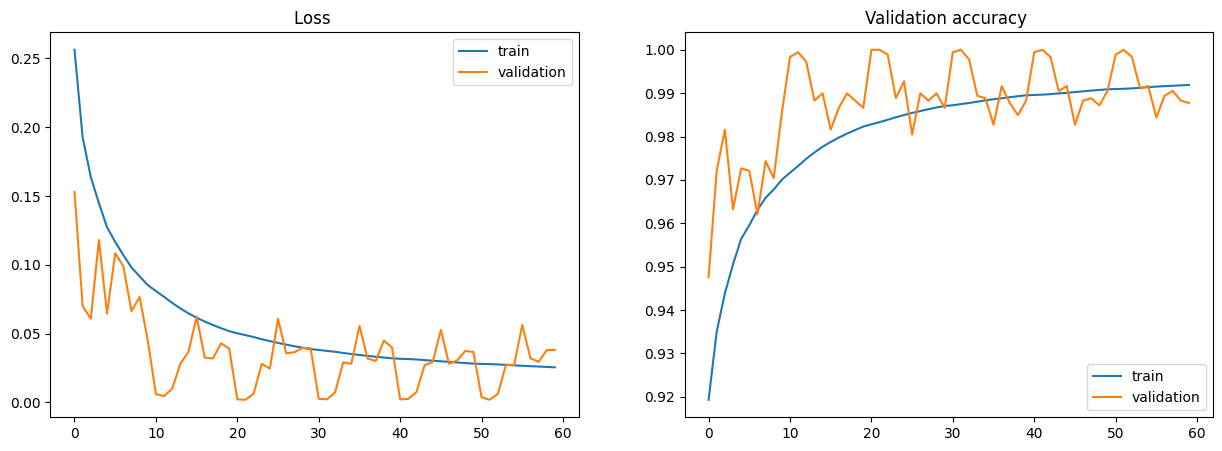

Epoch 1
avg train loss 30 iterations: 0.3265902534127235 accuracy: 0.893750011920929 
avg train loss 30 iterations: 0.31767323339978853 accuracy: 0.9005208611488342 
avg train loss 30 iterations: 0.29132012592421636 accuracy: 0.9083333611488342 
avg train loss 30 iterations: 0.2784990563367804 accuracy: 0.9117187261581421 
avg train loss 30 iterations: 0.2569602446382244 accuracy: 0.9191666841506958 
Epoch 1/60: val loss: 0.1528935681895486 accuracy: 0.9475446428571429 
New weights tensor([0.9004, 1.0000, 0.4247, 0.9724, 0.7038, 0.8030, 0.9120, 0.3791, 0.7032]) 
Learning rate 0.0001 
Epoch 2
avg train loss 30 iterations: 0.23684837002286596 accuracy: 0.924723744392395 
avg train loss 30 iterations: 0.22731804558168656 accuracy: 0.9265402555465698 
avg train loss 30 iterations: 0.21132242223982123 accuracy: 0.9306275844573975 
avg train loss 30 iterations: 0.20040630466026355 accuracy: 0.933002769947052 
avg train loss 30 iterations: 0.19260817749481463 accuracy: 0.9350082874298096 
Epo

In [ ]:
model.train(d_train)
model.save("best")

In [ ]:
model.save("best")

In [ ]:
model.load("best")

Downloading...
From (original): https://drive.google.com/uc?id=1-KG_C4OaeYnh9DpB4GH0_fdUoLK706Fg
From (redirected): https://drive.google.com/uc?id=1-KG_C4OaeYnh9DpB4GH0_fdUoLK706Fg&confirm=t&uuid=a1315c98-8002-48c5-b778-14fbd56f8e59
To: /content/best.pth
100%|██████████| 44.8M/44.8M [00:00<00:00, 80.8MB/s]
<ipython-input-65-62702a8d8649>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_g

Пример тестирования модели на части набора данных:

In [ ]:
# evaluating model on 10% of test dataset
 #(чет вообще все плохо с конф. матрицей, даже не знаю почему... но на другом тесте работает нормальноЫ)
pred_1 = model.test_on_dataset(d_test, limit=0.1)
#confi_matrix(d_test.labels[:len(pred_1)], pred_1, TISSUE_CLASSES)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

  0%|          | 0/450 [00:00<?, ?it/s]

metrics for 10% of test:
	 accuracy 0.9978:
	 balanced accuracy 0.9978:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

  0%|          | 0/4500 [00:00<?, ?it/s]

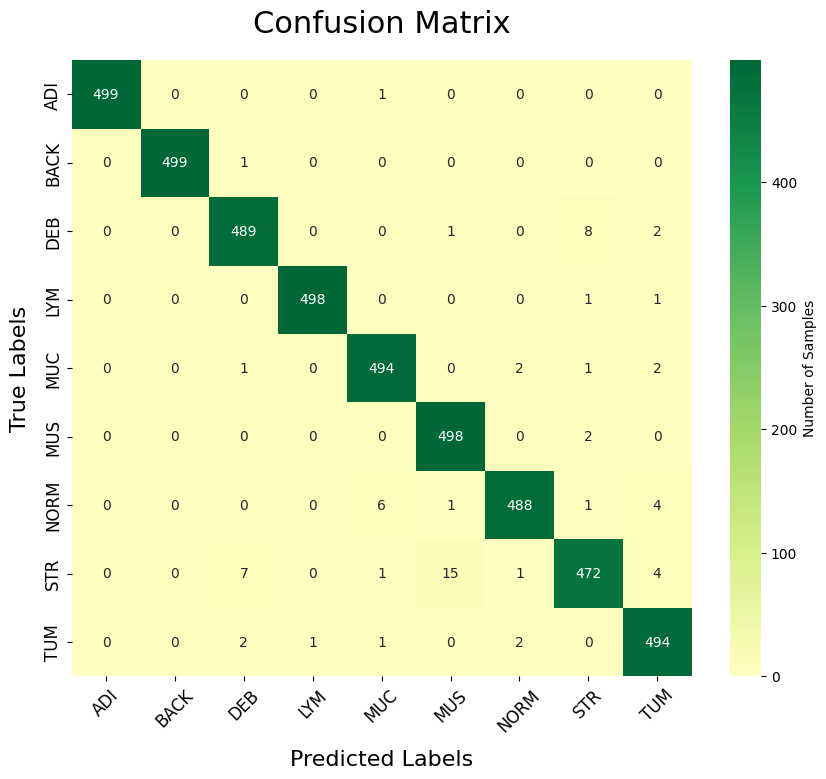

Class          True Positive (TP)  False Positive (FP) 
-------------------------------------------------------
ADI            499                 0                   
BACK           499                 0                   
DEB            489                 11                  
LYM            498                 1                   
MUC            494                 9                   
MUS            498                 17                  
NORM           488                 5                   
STR            472                 13                  
TUM            494                 13                  
metrics for test:
	 accuracy 0.9847:
	 balanced accuracy 0.9847:


In [ ]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    confi_matrix(d_test.labels, pred_2,  TISSUE_CLASSES)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [ ]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading...
From (original): https://drive.google.com/uc?id=1-KG_C4OaeYnh9DpB4GH0_fdUoLK706Fg
From (redirected): https://drive.google.com/uc?id=1-KG_C4OaeYnh9DpB4GH0_fdUoLK706Fg&confirm=t&uuid=33e5016e-feda-4ce4-95db-72b9eb7f4591
To: /content/best.pth
100%|██████████| 44.8M/44.8M [00:00<00:00, 75.3MB/s]
<ipython-input-65-62702a8d8649>:18: FutureWarning: You are using `tor

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9667:
	 balanced accuracy 0.9667:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dev/prak_nn_1/tmp'

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"

[Errno 2] No such file or directory: '/content/drive/MyDrive//dev/prak_nn_1/'
/content
unzip:  cannot find or open tmp.zip, tmp.zip.zip or tmp.zip.ZIP.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')